In [1]:
import matplotlib
from helper_functions import datamaker
from scipy.integrate import quad
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import pickle
import os
from matplotlib.ticker import FormatStrFormatter


from zipped_data_edited import gal

# Defining the Observables
q = Symbol('q')
omega = Symbol('\Omega')
sigma = Symbol('\Sigma')
sigmatot = Symbol('Sigma_tot')
sigmasfr = Symbol('Sigma_SFR')
T = Symbol('T')

# Defining the Constants
gamma = Symbol('gamma')
boltz = Symbol('k_B')
mu = Symbol('mu')
mh = Symbol('m_H')

# Defining the general parameters
u = Symbol('u')
tau = Symbol('tau')
l = Symbol('l')
h = Symbol('h')

# conversion factors
pc_kpc = 1e3  # number of pc in one kpc
cm_km = 1e5  # number of cm in one km
cm_kpc = 3.086e+21  # number of centimeters in one parsec
s_Myr = 1e+6*(365*24*60*60)  # megayears to seconds
deg_rad = 180e0/np.pi
arcmin_deg = 60e0
arcsec_deg = 3600e0

#######################################################################################################################################
##############################################################################################################################
current_directory=os.path.abspath(os.curdir)
#reading the parameters
params = {}
with open(current_directory+ '\parameter_file.in', 'r') as FH:
    for file in FH.readlines():
        line = file.strip()
        try:
            par_name, value = line.split('=')
        except ValueError:
            print("Record: ", line)
            raise Exception(
                "Failed while unpacking. Not enough arguments to supply.")
        try:
            params[par_name] = np.float64(value)
        except ValueError:
            num, denom = value.split('/')
            params[par_name] = np.float64(num) / np.float64(denom)

#####################################################################################################################
os.chdir(current_directory)     
#####################################################################################################################

# from data.data_magfield_observables_6946 import radius_po_borlaff23,po_borlaff23,radius_po_Surgent23,po_Surgent23,G_dat_Bord,G_dat_Breg,G_dat_Btot,RM_dat_po_range1,RM_dat_po_range2,err_RM_dat_po_range1,err_RM_dat_po_range2,rmdat_tanpo_range1,rmdat_tanpo_range2,rm_errdat_tanpo_range1,rm_errdat_tanpo_range2,range1,range2,mrange,kpc_dat_r,pc_dat_h
# from data.data_magfield_observables_m51 import radius_pB_surgent23,pB_surgent23,radius_pB_borlaff21,pB_borlaff21,radius_pB_borlaff23,pB_borlaff23,G_dat_Bord,G_dat_Breg,G_dat_Btot,range_po,RM_dat_po,err_RM_dat_po,rmdat_tanpo,rm_errdat_tanpo,M_dat_pb,err_M_dat_pb,m_errdat_tanpb,mrange,kpc_dat_r,pc_dat_h
from data.data_magfield_observables_m33 import G_dat_Bord,G_dat_Breg,G_dat_Btot,rmdat_tanpo,rm_errdat_tanpo,M_dat_pb,err_M_dat_pb,rm_errdat_tanpb,po_mrange,RM_dat_po,err_RM_dat_po, mrange,kpc_dat_r,pc_dat_h
# from data.data_magfield_observables_m31 import G_dat_Bord,G_dat_Breg,G_dat_Btot,RM_dat_po,err_RM_dat_po,RM_dat_pb,err_RM_dat_pb,M_dat_pb,err_M_dat_pb,mrange,rmrange,kpc_dat_r,pc_dat_h

#######################################################################################################################################
from get_magnetic_observables import omt, kah, taue_f, taur_f

#change file name here
with open(current_directory+r'\mag_observables_{}.pickle'.format(gal), 'rb') as f:
    kpc_r, h_f, l_f, u_f, cs_f, alphak_f, tau_f, biso_f, bani_f, Bbar_f, tanpB_f, tanpb_f = pickle.load(f)

# os.chdir(current_directory) 
# with open(current_directory+r'\errors_quan.pickle', 'rb') as f:
#      h_err, l_err, u_err, cs_err, alphak_err, tau_err, biso_err, bani_err, Bbar_err, tanpB_err, tanpb_err = pickle.load(f)

os.chdir(current_directory+'\data')
with open('zip_data.pickle', 'rb') as f:
    kpc_r, data_pass = pickle.load(f)
#######################################################################################################################################

os.chdir(current_directory+'\expressions')
from expressions.magnetic_expressions import Dk, Dc

dkdc_f = datamaker((Dk/Dc), data_pass, h_f, tau_f, alphak_f)
alpham_f = alphak_f*((1/dkdc_f)-1)
alphasat_f = alphak_f + alpham_f
#####################################################################################################################################
os.chdir(current_directory)
#########################################################################################################################################################

# M31
# # from data.data_conv_M31 import kpc_r, dat_u,dat_u_warp
# from data.data_M31 import kpc_r, dat_u,dat_u_warp
# corrected_radius=kpc_r
#########################################################################################################################################################

# M51
# from data.data_m51 import nandeleted_data,vel_disp  
# corrected_radius,dat_sigmatot,dat_sigma_HI,dat_sigma_H2, dat_q, dat_omega, dat_sigmasfr,temp=nandeleted_data
# dat_u=vel_disp #this has been interpolated in data.m51
#########################################################################################################################################################
# M33
from data.data_conv_M33 import nandeleted_data,data_v_disp
corrected_radius,dat_sigmatot,dat_sigmaHI,dat_sigmaH2, dat_q, dat_omega, dat_sigmasfr,temp=nandeleted_data
dat_u=data_v_disp
#########################################################################################################################################################
# 6946
# from data.data_6946 import nandeleted_data,vel_disp  
# corrected_radius,dat_sigmatot,dat_sigmaHI,dat_sigmaH2, dat_q, dat_omega, dat_sigmasfr,temp=nandeleted_data
# dat_u=vel_disp
#########################################################################################################################################################

os.chdir(current_directory)

pB = np.arctan(-tanpB_f)
# pB_err = -tanpB_err/(1+tanpB_f**2)
pbb = np.arctan(tanpb_f)
# pbb_err = tanpb_err/(1+tanpb_f**2)
pbo = (1/2)*((1+(2*Bbar_f*bani_f*np.cos(pbb-pB))/
              (bani_f**2+Bbar_f**2))*np.arctan((Bbar_f*np.sin(pB) + bani_f*np.sin(pbb))/
                                               ((Bbar_f*np.cos(pB)) + bani_f*np.cos(pbb)))
                                                        + (1-(2*Bbar_f*bani_f*np.cos(pbb-pB))/
                                                           (bani_f**2+Bbar_f**2))*np.arctan((Bbar_f*np.sin(pB) - bani_f*np.sin(pbb))/
                                                                                            ((Bbar_f*np.cos(pB)) - bani_f*np.cos(pbb))))

def pogen(b, B, pb, pB, s):
    return (np.exp(-b**2/(2*s**2))/
            (np.sqrt(2*(np.pi))*s))*(1+(2*B*b*np.cos(pb-pB))/
                                     (b**2 + B**2))*np.arctan((B*np.sin(pB) + b*np.sin(pb))/
                                                                                            ((B*np.cos(pB)) + b*np.cos(pb)))
brms = np.sqrt(np.average(bani_f**2))

h = 1e-8 #here h is the tolerance
def dpodbani(b, B, pb, pB, s):
    return (pogen(b, B, pb, pB, s+h)-pogen(b, B, pb, pB, s-h))/(2*h)
def dpodBbar(b, B, pb, pB, s):
    return (pogen(b, B+h, pb, pB, s)-pogen(b, B-h, pb, pB, s))/(2*h)
h = 0.01 #here h is the tolerance
def dpodpB(b, B, pb, pB, s):
    return (pogen(b, B, pb, pB+h, s)-pogen(b, B, pb, pB-h, s))/(2*h)
def dpodpb(b, B, pb, pB, s):
    return (pogen(b, B, pb+h, pB, s)-pogen(b, B, pb-h, pB, s))/(2*h)

def integrator(fn, interval = 1e-3):
    return np.array([quad(fn, 1e-11, 1e-9, args=(Bbar_f[i], pbb[i], pB[i], bani_f[i]),
               points=[-interval*brms, interval*brms])[0] for i in range(len(kpc_r))])
pog = integrator(pogen)
inte = 1e-10
pog_err = np.array([quad(pogen, -inte, inte, args=(Bbar_f[i], pbb[i], pB[i], bani_f[i]),
                points=[-inte*brms, inte*brms])[1] for i in range(len(kpc_r))]) 
# pog_err += np.sqrt((integrator(dpodbani,inte)*bani_err)**2 +(integrator(dpodBbar,inte)*Bbar_err)**2
#                   +(integrator(dpodpB,inte)*pB_err)**2+(integrator(dpodpb,inte)*pbb_err)**2)

G_scal_Bbartot = np.sqrt(biso_f**2 + bani_f**2 + Bbar_f**2)
G_scal_Bbarreg = Bbar_f
G_scal_Bbarord = np.sqrt(bani_f**2 + Bbar_f**2)

# G_scal_Bbartot_err = np.sqrt((biso_err*biso_f )**2+ (bani_err*bani_f)**2 + (Bbar_err*Bbar_f)**2)/G_scal_Bbartot
# G_scal_Bbarreg_err = Bbar_err
# G_scal_Bbarord_err = np.sqrt((bani_err*bani_f)**2 + (Bbar_err*Bbar_f)**2)/G_scal_Bbarord

os.chdir(current_directory)


Succesfully read the parameters and switches
switch for moldat No
Succesfully zipped the data and the parameters, and made pickle file
(0.0016204028745023307, 0.000894393400944541, 7.378053799198658e-22, 0.7610567306212648, 4.1083790551939496e-16, 15.0, 5772.1441066222405, 1.0, 7.0, 4.0, 0.03, 1.2727272727272727, 1.414)
Root found succesfully
Solved the magnetic expressions


In [2]:
from zipped_data_edited import save_files_dir
saver=current_directory+save_files_dir


In [3]:
m = 2
dm = 2.5
fs = 15
lfs = 10
leg_textsize = 13
axis_textsize = 12
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "xtick.labelsize": fs,  # X-axis label font size
      "ytick.labelsize": fs,}  # Y-axis label font size
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rc('xtick', labelsize=fs)
matplotlib.rc('ytick', labelsize=fs)
matplotlib.ticker.AutoMinorLocator(n=None)
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["legend.loc"] = 'upper right'
plt.rcParams["errorbar.capsize"] = 2

# plt.legend(fontsize=14)
# plt.minorticks_on()
# plt.tick_params(axis='both',labelsize=12, which='both', width=2)
# plt.xlabel('r [kpc]',fontsize=13)
# plt.ylabel('$V_c$ [$kms^{-1}$]',fontsize=13)


In [4]:
#change axis params here
def axis_pars(ax):
    ax.xaxis.set_ticks(np.arange(0,9, 1))  #20 for ngc, 10 for M51, 9 for M33
    # ax.xaxis.set_ticks(np.arange(6,20, 1)) # for m31 only
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.tick_params(axis='both', which='minor',
                   labelsize=axis_textsize, colors='k', length=3, width=1)
    ax.tick_params(axis='both', which='major',
                   labelsize=axis_textsize, colors='k', length=5, width=1.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.legend(fontsize=lfs, frameon=False, handlelength=4, ncol=1, prop={
            'size': leg_textsize, 'family': 'Times New Roman'}, fancybox=True, framealpha=0.9, handletextpad=0.7, columnspacing=0.7)
    
def fill_error(ax, quan_f, quan_err, color = 'red', alpha = 0.2):
    ax.fill_between(kpc_r, (quan_f+quan_err), (quan_f-quan_err)
                    , alpha=alpha, edgecolor='k', facecolor=color, where = None, interpolate=True)


### plotting h

h sup [] []
[] []
l sup [] []
[] []
[147.72962766 166.26368615 189.62583893 200.64649696 218.86454708
 259.99272931 244.76846759 254.46400784 266.69996162 283.21599281
 301.70840551 298.00743003 336.55658827 430.6659549  625.15300801]
[0.7504 1.257  1.752  2.259  2.754  3.249  3.756  4.251  4.758  5.253
 5.748  6.243  6.75   7.245  7.752 ]


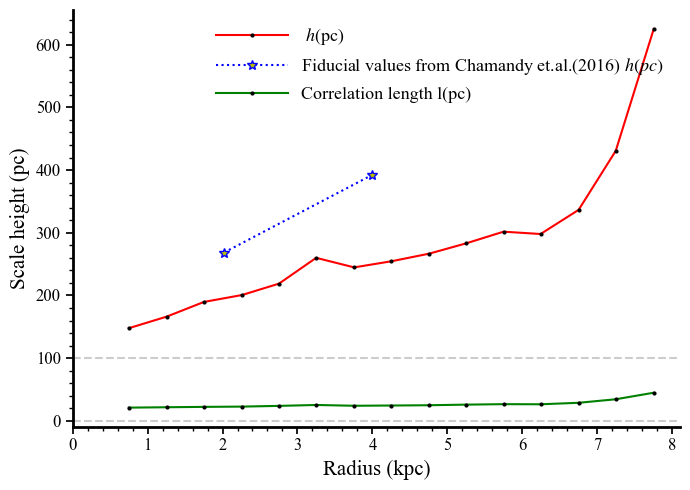

In [5]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, h_f*pc_kpc/cm_kpc, c='r', linestyle='-', mfc='k',
              mec='k', markersize=m, marker='o', label=r' $h$(pc)')
ax.plot(kpc_dat_r, pc_dat_h, c='b', linestyle='dotted', 
              marker='*',mfc='y',mec='b',mew=1, markersize = 7, label=r'Fiducial values from Chamandy et.al.(2016) $h(pc)$')
ax.plot(kpc_r, l_f*pc_kpc/cm_kpc, c='g',
              linestyle='-', mfc='k', mec='k', markersize=m, marker='o', label=r'Correlation length l(pc)')
# ax.plot(kpc_r, datamaker(lsn , data_pass, h_f, tau_f)*pc_kpc/cm_kpc,c = 'y',linestyle='--',mfc='k',mec='k', marker='o')
ax.axhline(y=100, color='black', linestyle='--', alpha = 0.2)
# ax.set_yticks(list(plt.yticks()[0])+[100])
axis_pars(ax)
# fill_error(ax, h_f*pc_kpc/cm_kpc, h_err*pc_kpc/cm_kpc)
ax.set_xlabel(r'Radius (kpc)', fontsize=fs)
ax.set_ylabel(r'Scale height (pc)', fontsize=fs)
ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)



hf=h_f*(pc_kpc/cm_kpc)
lf=l_f*(pc_kpc/cm_kpc)
index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('h sup',hf[index_sup],kpc_r[index_sup])
print(hf[index_sub],kpc_r[index_sub])
print('l sup',lf[index_sup],kpc_r[index_sup])
print(lf[index_sub],kpc_r[index_sub])

print(hf)
print(kpc_r)
plt.savefig(save_files_dir+r'\1 h,l')



[21.03128125 21.63403526 22.22755472 22.66639207 23.81847964 25.27068111
 24.00359686 24.40105341 24.84657018 25.81250839 26.55226254 26.37344889
 28.74625656 34.3661787  44.81142168]


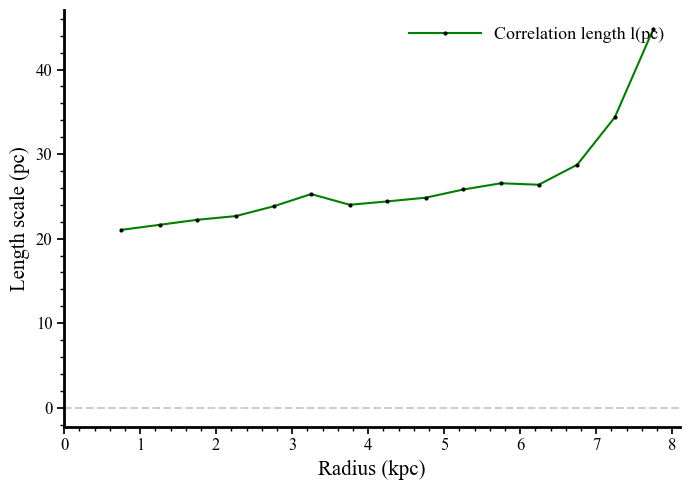

In [6]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

ax.plot(kpc_r, l_f*pc_kpc/cm_kpc, c='g',
              linestyle='-', mfc='k', mec='k', markersize=m, marker='o', label=r'Correlation length l(pc)')
# ax.plot(kpc_r, datamaker(lsn , data_pass, h_f, tau_f)*pc_kpc/cm_kpc,c = 'y',linestyle='--',mfc='k',mec='k', marker='o')
# ax.axhline(y=100, color='black', linestyle='--', alpha = 0.2)
# ax.set_yticks(list(plt.yticks()[0])+[100])
axis_pars(ax)
# fill_error(ax, h_f*pc_kpc/cm_kpc, h_err*pc_kpc/cm_kpc)
ax.set_xlabel(r'Radius (kpc)', fontsize=fs)
ax.set_ylabel(r'Length scale (pc)', fontsize=fs)
ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

print(l_f*pc_kpc/cm_kpc)
plt.savefig(save_files_dir+r'\2 correlation length')


### plotting u

uf [8.18591208 7.74469532 7.75618899 6.9504521  6.27207793 6.98658791
 5.97660983 5.46494653 5.15003151 4.65023137 4.59232715 3.75445064
 3.26488517 2.92469091 3.06556343]
cs [6.28401545 6.37906034 6.47058056 6.56299656 6.6519866  6.73980174
 6.82857515 6.91414785 7.00071078 7.0842045  7.16672556 7.24830719
 7.33092546 7.4106997  7.49152729]
sig [10.31978715 10.03357945 10.10083563  9.55937803  9.14264115  9.70759178
  9.07465171  8.81311983  8.69095944  8.47411383  8.51184022  8.16295637
  8.02508214  7.96694966  8.09448332]
***********************************************************************************************************
alpha_k [0.78468678 0.54023641 0.41059988 0.34794113 0.30835624 0.25714194
 0.21876343 0.19799841 0.17969337 0.1681976  0.155764   0.14379707
 0.14096891 0.14753216 0.16289867]
alpha_m [-0.4448436  -0.30375848 -0.19471456 -0.18071573 -0.1932127  -0.15848078
 -0.13017444 -0.11966426 -0.11470819 -0.11702103 -0.11154378 -0.11380497
 -0.12023022 -0.13531814 -0.1

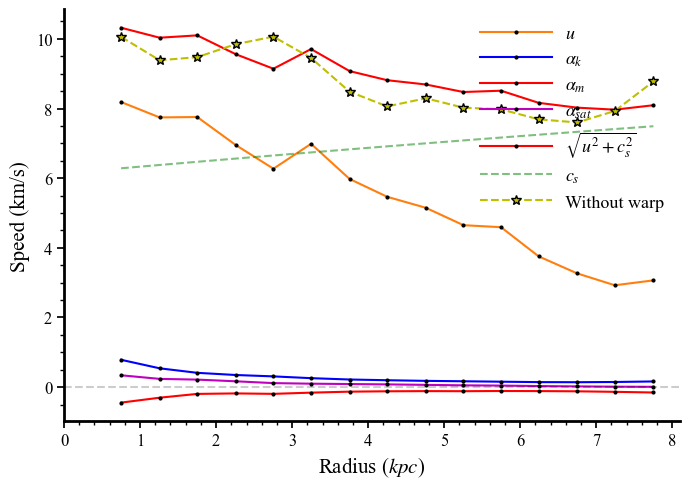

In [7]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, u_f/cm_km, color='tab:orange', marker='o', mfc='k',
              mec='k', markersize=m, label=r'$u$')
# fill_error(ax, u_f/cm_km,u_err/cm_km, 'tab:orange', 0.5)

ax.plot(kpc_r, alphak_f/cm_km, color='b', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_k$')
# fill_error(ax, alphak_f/cm_km,alphak_err/cm_km, 'blue')

ax.plot(kpc_r, alpham_f/cm_km, color='r', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_m$')
ax.plot(kpc_r, alphasat_f/cm_km, color='m', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_{sat}$')

sig = np.sqrt(u_f**2 + (cs_f)**2) 
ax.plot(kpc_r, sig /
              cm_km, color='r', marker='o', mfc='k', mec='k', markersize=m, label=r'$\sqrt{u^2+c_s^2}$')
# fill_error(ax, sig /cm_km,np.sqrt((u_f*u_err)**2 + (cs_f*cs_err)**2)/(sig*cm_km), 'r')

ax.plot(kpc_r, cs_f /
              cm_km, color='g', linestyle='--', label=r'$c_s$', alpha = 0.5)
# fill_error(ax, cs_f/cm_km,cs_err/cm_km, 'green')

ax.plot(corrected_radius, dat_u, 
              c='y', linestyle='--', label='Without warp',alpha = 1,marker='*',mfc='y',mec='k',mew=1, markersize = 7)

ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

#next line is for warped u data for M31
# ax.plot(kpc_r, dat_u_warp, 
#               c='tab:cyan',  linestyle='dashdot', label='With warp', alpha = 0.3,marker='*',mfc='tab:cyan',mec='k',mew=1, markersize = 7)
axis_pars(ax)


uf=u_f/cm_km
csf=cs_f/cm_km
sigf=sig /cm_km
# index_sup = np.where(kpc_r== 8.75)
# index_sub = np.where(kpc_r== 14.25)
# print('sup u',uf[index_sup],kpc_r[index_sup])
# print(uf[index_sub],kpc_r[index_sub])
# print('sup cs',csf[index_sup],kpc_r[index_sup])
# print(csf[index_sub],kpc_r[index_sub])
# print('sup sig',sigf[index_sup],kpc_r[index_sup])
# print(sigf[index_sub],kpc_r[index_sub])
# print('***********************************************************************************************************')
akf=alphak_f/cm_km
amf=alpham_f/cm_km
asf=alphasat_f/cm_km
# index_sup = np.where(kpc_r== 8.75)
# index_sub = np.where(kpc_r== 14.25)
# print('sup ak',akf[index_sup],kpc_r[index_sup])
# print(akf[index_sub],kpc_r[index_sub])
# print('sup am',amf[index_sup],kpc_r[index_sup])
# print(amf[index_sub],kpc_r[index_sub])
# print('sup as',asf[index_sup],kpc_r[index_sup])
# print(asf[index_sub],kpc_r[index_sub])
# print('***********************************************************************************************************')

print('uf',uf)
print('cs',csf)
print('sig',sigf)
print('***********************************************************************************************************')
print('alpha_k',akf)
print('alpha_m',amf)
print('alpha_s',asf)


#ax.set_ylim(0)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'Speed (km/s)',  fontsize=fs)

plt.savefig(save_files_dir+r'\3 speeds')

# print(sigf)


[1.30265626 1.2140809  1.19868518 1.05903638 0.94288794 1.03661624
 0.87523527 0.79040059 0.73564409 0.65642252 0.64078457 0.5179762
 0.44535784 0.39465786 0.40920407]


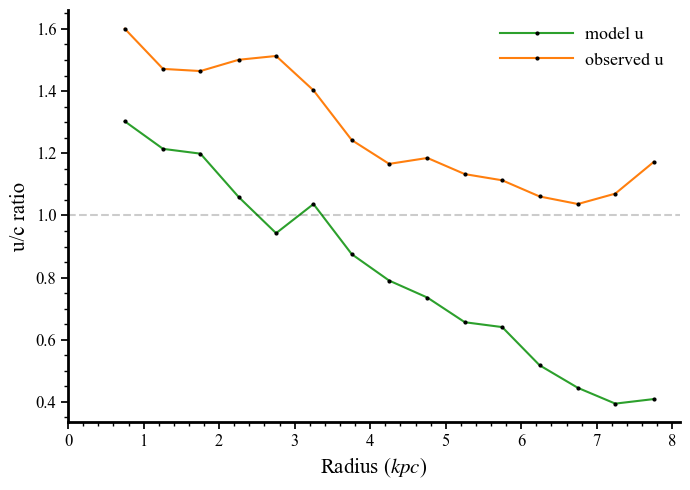

In [8]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, (u_f/cm_km)/(cs_f /cm_km), color='tab:green', marker='o', mfc='k',
              mec='k', markersize=m, label=r'model u')
ax.plot(kpc_r, (dat_u)/(cs_f /cm_km), color='tab:orange', marker='o', mfc='k',
              mec='k', markersize=m, label=r'observed u')

ax.axhline(y=1, color='black', linestyle='--', alpha = 0.2)

axis_pars(ax)

#ax.set_ylim(0)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'u/c ratio',  fontsize=fs)

plt.savefig(save_files_dir+r'\4 u by c')

ratio=(u_f/cm_km)/(cs_f /cm_km)
print(ratio)



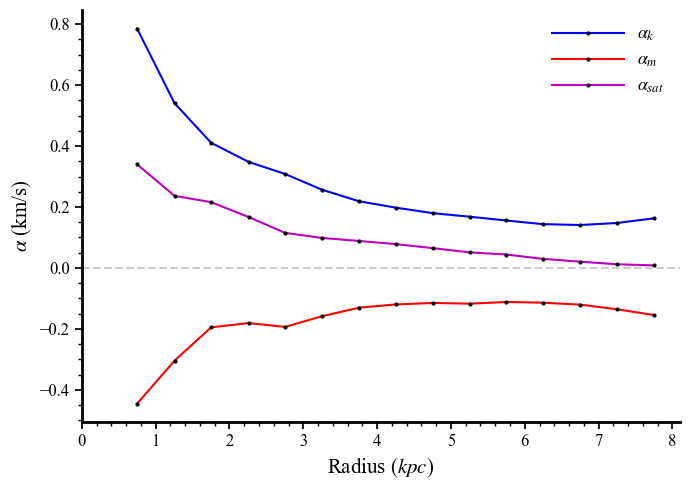

In [9]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

ax.plot(kpc_r, alphak_f/cm_km, color='b', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_k$')
# fill_error(ax, alphak_f/cm_km,alphak_err/cm_km, 'blue')

ax.plot(kpc_r, alpham_f/cm_km, color='r', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_m$')
ax.plot(kpc_r, alphasat_f/cm_km, color='m', marker='o',
              mfc='k', mec='k', markersize=m, label=r'$\alpha_{sat}$')

axis_pars(ax)
ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

# ax.set_ylim(0)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'$\alpha$ (km/s)',  fontsize=fs)

plt.savefig(save_files_dir+r'\5 alpha')



### plotting magnetic fields

In [10]:
# without observational data

# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
# ax.plot(kpc_r, G_scal_Bbartot*1e+6, c='b', linestyle='-', marker='o', mfc='k', mec='k',
#               markersize=m, label=r' $B_{tot}=\sqrt{\bar{B}^2+b_{iso}^2+b_{ani}^2}$')
# fill_error(ax, G_scal_Bbartot*1e+6,G_scal_Bbartot_err*1e+6, 'b')

# ax.plot(kpc_r, G_scal_Bbarreg*1e+6, c='r', linestyle='-', marker='o',
#               mfc='k', mec='k', markersize=m, label=r' $B_{reg} = \bar{B}$')
# fill_error(ax, G_scal_Bbarreg*1e+6,G_scal_Bbarreg_err*1e+6, 'r', 0.2)


# ax.plot(kpc_r, G_scal_Bbarord*1e+6, c='green', linestyle='-', marker='o', mfc='k',
#               mec='k', markersize=m, label=r' $B_{ord} = \sqrt{\bar{B}^2+b_{ani}^2}$')
# fill_error(ax, G_scal_Bbarord*1e+6,G_scal_Bbarord_err*1e+6, 'g', 0.2)

# ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

# ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
# ax.xaxis.set_ticks(np.arange(4, 9, 1))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# ax.set_ylabel('Magnetic field strength ($\mu G$)', fontsize=fs)
# axis_pars(ax)

G_scal_Bbartot [] []
[] []
G_scal_Bbarreg [] []
[] []
G_scal_Bbarord [] []
[] []
G_scal_Bbartot [13.63784921 12.3108153  11.6787364  10.14726357  8.58287903  8.73462723
  7.94961615  7.06537268  6.47400743  5.54786262  5.25328766  4.36624003
  3.40659873  2.45252612  1.82319905]
G_scal_Bbarreg [2.5879907  2.12011697 1.53579657 1.40528195 1.41574938 1.26540698
 1.11271511 0.98677507 0.94259121 0.89563191 0.85918324 0.8698201
 0.79975556 0.72457972 0.6086138 ]
G_scal_Bbarord [3.925054   3.45049433 2.79141845 2.49245351 2.34945329 2.23579191
 1.99914095 1.75540381 1.65159657 1.49784288 1.43754834 1.36477288
 1.17757386 0.99319489 0.8003371 ]


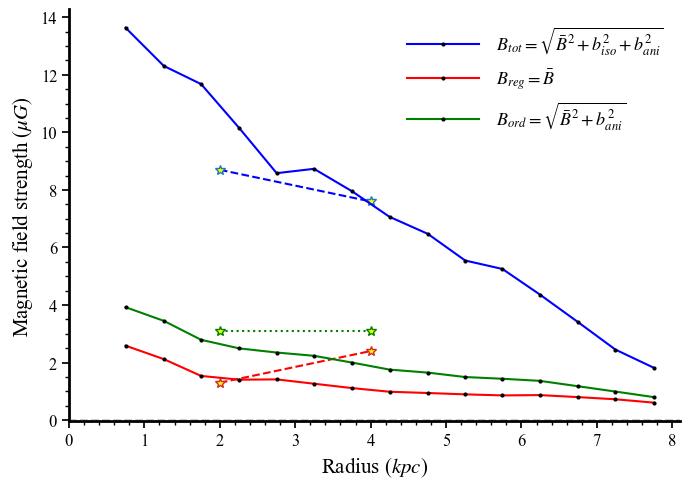

In [11]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(mrange, G_dat_Btot, c='b', linestyle='--', marker='*',mfc='yellow',mec='tab:blue',mew=1,markersize = 7)#, label='Average Binned data $B_{tot}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbartot*1e+6, c='b', linestyle='-', marker='o', mfc='k', mec='k',
              markersize=m, label=r' $B_{tot}=\sqrt{\bar{B}^2+b_{iso}^2+b_{ani}^2}$')
# fill_error(ax, G_scal_Bbartot*1e+6,G_scal_Bbartot_err*1e+6, 'b')

ax.plot(mrange, G_dat_Breg, c='r', linestyle='--', marker='*',mfc='yellow',mec='tab:red',mew=1,markersize = 7)#, label='Average Binned data $B_{reg}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbarreg*1e+6, c='r', linestyle='-', marker='o',
              mfc='k', mec='k', markersize=m, label=r' $B_{reg} = \bar{B}$')
# fill_error(ax, G_scal_Bbarreg*1e+6,G_scal_Bbarreg_err*1e+6, 'r', 0.2)


ax.plot(mrange, G_dat_Bord, c='g', linestyle='dotted', marker='*',mfc='yellow',mec='green',mew=1,markersize = 7)#, label='Average Binned data $B_{ord}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbarord*1e+6, c='green', linestyle='-', marker='o', mfc='k',
              mec='k', markersize=m, label=r' $B_{ord} = \sqrt{\bar{B}^2+b_{ani}^2}$')
# fill_error(ax, G_scal_Bbarord*1e+6,G_scal_Bbarord_err*1e+6, 'g', 0.2)

ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.xaxis.set_ticks(np.arange(6, 9, 1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel('Magnetic field strength ($\mu G$)', fontsize=fs)
axis_pars(ax)

G_scal_Bbartot=G_scal_Bbartot*1e+6
G_scal_Bbarreg=G_scal_Bbarreg*1e+6
G_scal_Bbarord=G_scal_Bbarord*1e+6
index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('G_scal_Bbartot',G_scal_Bbartot[index_sup],kpc_r[index_sup])
print(G_scal_Bbartot[index_sub],kpc_r[index_sub])
print('G_scal_Bbarreg',G_scal_Bbarreg[index_sup],kpc_r[index_sup])
print(G_scal_Bbarreg[index_sub],kpc_r[index_sub])
print('G_scal_Bbarord',G_scal_Bbarord[index_sup],kpc_r[index_sup])
print(G_scal_Bbarord[index_sub],kpc_r[index_sub])

print('G_scal_Bbartot',G_scal_Bbartot)
print('G_scal_Bbarreg',G_scal_Bbarreg)
print('G_scal_Bbarord',G_scal_Bbarord)

plt.savefig(save_files_dir+r'\6 B')


pB [] []
[] []
pbb [] []
[] []
po [] []
[] []
pB [12.71978231 10.29487742 10.41464621  9.36125224  7.43915673  6.41636078
  6.67295817  6.59994692  5.98496484  5.33959802  4.84086664  3.99668264
  3.29454425  2.31971737  1.71614567]
pbb [42.96060198 42.88577977 43.29164341 43.23288331 42.940577   43.08740073
 43.12718694 43.18732735 43.11427106 42.98060723 42.92422456 42.4767798
 42.16412721 41.52539092 41.23095466]
po [21.34760493 18.13104336 36.22158869 35.81265769 15.14935361 35.46817169
 35.70673678 35.64878784 35.38259376 13.02817422 12.54163001 12.75878358
 12.65439204 11.72283668 10.80571704]


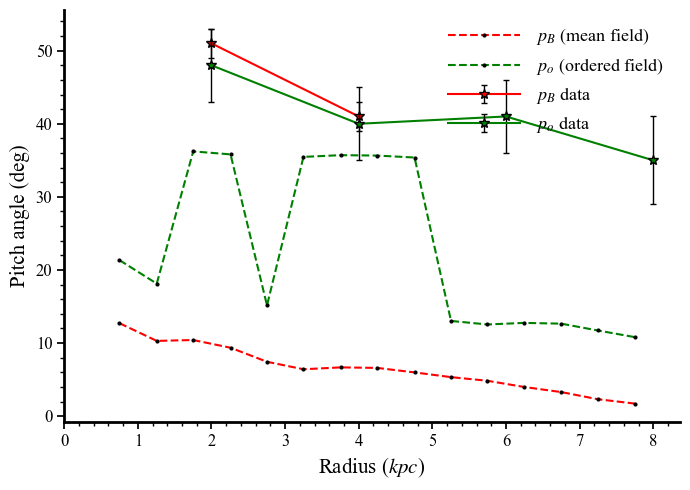

In [12]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

###################################     M31    ######################################################################
# ax.errorbar(mrange, 180*M_dat_pb/np.pi,elinewidth=1, yerr=180*err_M_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
#                   c='r', linestyle='-', mfc='r', mec='k',label=r' $p_{B}$ (M)',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
# ax.errorbar(rmrange, 180*RM_dat_pb/np.pi,elinewidth=1, yerr=180*err_RM_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
#                   c='r', linestyle='-', mfc='r', mec='k',label=r' $p_{B}$ (RM)',barsabove=True,marker='o')#, label=r'Data $p_{B}$ (mean field)(RM)')
# ax.errorbar(rmrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
#                   c='g', linestyle='-', marker='*', mfc='g', mec='k',label=r'$p_{o}$ data',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')

# ax.plot(kpc_r, 180*pB/np.pi, c='r', linestyle='--', marker='o',
#               markersize=m, mfc='k', mec='k', label=r' $p_{B}$ (mean field)')
# # fill_error(ax, 180*pB/np.pi,180*pB_err/np.pi, 'r')
# ax.plot(kpc_r, 180*pbb/np.pi,c = 'b',linestyle='--', marker='o',label = r' $p_{b}$ (anisotropic field)')
# ax.plot(kpc_r, 180*pbo/np.pi, c='g', linestyle='--', mfc='k', markersize=m,mec='k', marker='o', label=r' $p_{o}$ (ordered field)')
# # fill_error(ax, 180*pog/np.pi,180*pog_err/np.pi, 'g')
###################################     M31     ######################################################################

###################################     M33     ######################################################################
ax.errorbar(mrange, 180*M_dat_pb/np.pi,elinewidth=1, yerr=180*err_M_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
                  c='r', linestyle='-', mfc='r', mec='k',label=r' $p_{B}$ data',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
ax.errorbar(po_mrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
                  c='g', linestyle='-', marker='*', mfc='g', mec='k',label=r' $p_{o}$ data',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')

ax.plot(kpc_r, 180*pB/np.pi, c='r', linestyle='--', marker='o',
              markersize=m, mfc='k', mec='k', label=r' $p_{B}$ (mean field)')
# fill_error(ax, 180*pB/np.pi,180*pB_err/np.pi, 'r')
# ax.plot(kpc_r, 180*pbb/np.pi,c = 'b',linestyle='--', marker='o',label = r' $p_{b}$ (anisotropic field)')
ax.plot(kpc_r, 180*pbo/np.pi, c='g', linestyle='--', mfc='k', markersize=m,mec='k', marker='o', label=r' $p_{o}$ (ordered field)')
# fill_error(ax, 180*pog/np.pi,180*pog_err/np.pi, 'g')
###################################     M33     ######################################################################

###################################     M51     ######################################################################
# ax.errorbar(mrange, 180*M_dat_pb/np.pi,elinewidth=1, yerr=180*err_M_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
#                   c='r', linestyle='--', mfc='r', mec='k',label=r' $p_{B}$ data (M)',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')

# #Beck+19
# ax.errorbar(range_po, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
#                   c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k', label=r'$p_{o}$ Beck+19')
# #Borlaff+23 data
# ax.plot(radius_pB_borlaff23, pB_borlaff23, c='magenta', linestyle='-', marker='*',
#               markersize=m, mfc='k', mec='k', label=r' $p_{o}$ Borlaff+23 (i=$22^\circ$)')

# #Borlaff+21 data
# ax.plot(radius_pB_borlaff21, pB_borlaff21, c='black', linestyle='-', marker='*',
#               markersize=m, mfc='k', mec='k', label=r' $p_{o}$ Borlaff+21 (i=$22.5^\circ$)')

# #Surgent+23 data
# ax.plot(radius_pB_surgent23, pB_surgent23, c='b', linestyle='-', marker='*',
#               markersize=m, mfc='k', mec='k', label=r' $p_{o}$ Surgent+23 (i=$22.5^\circ$)')


# ax.plot(kpc_r, 180*pB/np.pi, c='r', linestyle='-', marker='*',
#               markersize=m, mfc='k', mec='k', label=r' $p_{B}$')
# # fill_error(ax, 180*pB/np.pi,180*pB_err/np.pi, 'r')

# #pb is commented out
# # ax.plot(kpc_r, 180*pbb/np.pi,c = 'r',linestyle='--', marker='o',label = r' $p_{b}$')

# ax.plot(kpc_r, 180*pbo/np.pi, c='g', linestyle='-', mfc='k', markersize=m,mec='k', marker='*', label=r' $p_{o}$ Beck+19')
# # fill_error(ax, 180*pog/np.pi,180*pog_err/np.pi, 'g')
###################################     M51     ######################################################################

###################################     NGC 6946     ######################################################################
# print('no pB data for 6946 currently')

# #Borlaff+23
# ax.plot(radius_po_borlaff23, po_borlaff23, c='black', linestyle='-', marker='o',
#               markersize=m, mfc='k', mec='k', label=r' $p_{o}$ Borlaff+23 (i= $38.4^\circ)$')

# #Surgent+23
# ax.plot(radius_po_Surgent23, po_Surgent23, c='magenta', linestyle='-', marker='o',
#               markersize=m, mfc='k', mec='k', label=r' $p_{o}$ Surgent+23 (i= $38.4^\circ)$')

# #Beck+19
# ax.errorbar(range1, 180*RM_dat_po_range1/np.pi,elinewidth=1, yerr=180*err_RM_dat_po_range1/np.pi, ms=7, mew=1, capsize=2,
#                    c='blue', linestyle='-', marker='o', mfc='g',label=r' $p_{o}$ range1 (i= $30^\circ$)', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')
# ax.errorbar(range2, 180*RM_dat_po_range2/np.pi,elinewidth=1, yerr=180*err_RM_dat_po_range2/np.pi, ms=7, mew=1, capsize=2,
#                    c='orange', linestyle='-', marker='o', mfc='g',label=r' $p_{o}$ range2 (i= $30^\circ$)', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')

# #model values
# ax.plot(kpc_r, 180*pB/np.pi, c='r', linestyle='--', marker='o',markersize=m, mfc='k', mec='k', label=r' $p_{B}$')
# ax.plot(kpc_r, 180*pbo/np.pi, c='g', linestyle='--', mfc='k', markersize=m,mec='k', marker='o', label=r'$p_{o}$')
# # ax.plot(kpc_r, 180*pbb/np.pi,c = 'r',linestyle='--', marker='o',label = r'$p_{b}$')
# # fill_error(ax, 180*pB/np.pi,180*pB_err/np.pi, 'r')
# # fill_error(ax, 180*pog/np.pi,180*pog_err/np.pi, 'g')
###################################     NGC 6946     ######################################################################


pB=180*pB/np.pi
pbb=180*pbb/np.pi
po=180*pbo/np.pi
index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('pB',pB[index_sup],kpc_r[index_sup])
print(pB[index_sub],kpc_r[index_sub])
print('pbb',pbb[index_sup],kpc_r[index_sup])
print(pbb[index_sub],kpc_r[index_sub])
print('po',po[index_sup],kpc_r[index_sup])
print(po[index_sub],kpc_r[index_sub])

axis_pars(ax)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'Pitch angle (deg)', fontsize=fs)

plt.savefig(save_files_dir+r'\7 pitch angles')
print('pB',pB)
print('pbb',pbb)
print('po',po)



omt [] []
[] []
kah [] []
[] []


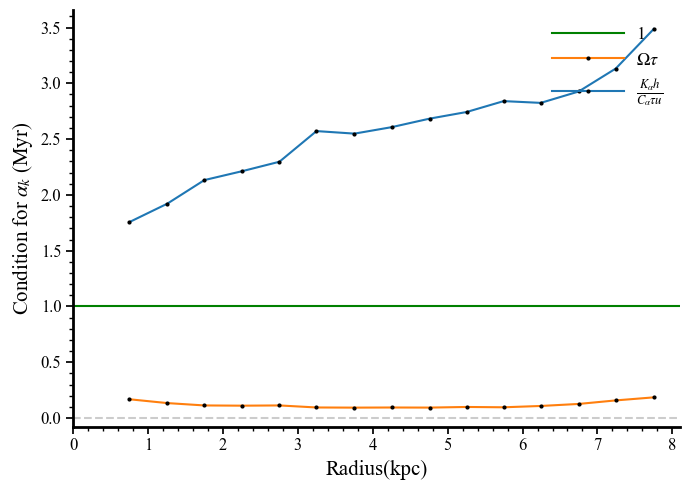

In [13]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.axhline(y=1, color='g', linestyle='-', label=r'1')
ax.plot(kpc_r, omt, marker='o', markersize=m,
              c='tab:orange', mfc='k', mec='k', label=r'$\Omega\tau$')
ax.plot(kpc_r, kah, marker='o',
              markersize=m, c='tab:blue', mfc='k', mec='k', label=r'$\frac{K_\alpha h}{C_\alpha \tau u}$')
ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

axis_pars(ax)
ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'Condition for $\alpha_k$ (Myr)', fontsize=fs)


index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('omt',omt[index_sup],kpc_r[index_sup])
print(omt[index_sub],kpc_r[index_sub])
print('kah',kah[index_sup],kpc_r[index_sup])
print(kah[index_sub],kpc_r[index_sub])
plt.savefig(save_files_dir+r'\8 condition for alpha_k')






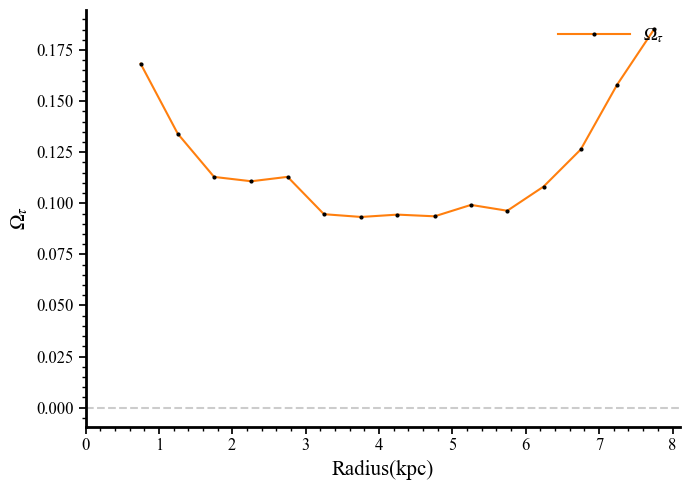

In [14]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
# ax.axhline(y=1, color='g', linestyle='-', label=r'1')
ax.plot(kpc_r, omt, marker='o', markersize=m,
              c='tab:orange', mfc='k', mec='k', label=r'$\Omega_\tau$')

ax.axhline(y=0, color='black', linestyle='--', alpha = 0.2)

axis_pars(ax)
ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'$\Omega_\tau$', fontsize=fs)

plt.savefig(save_files_dir+r'\8a Omega_tau$ in condition for alpha_k')



tauef [] []
[] []
taurf [] []
[] []
t [] []
[] []


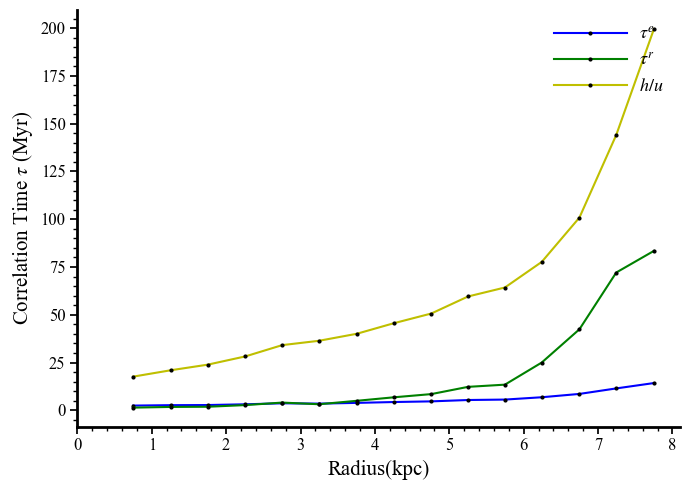

In [15]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, taue_f/s_Myr, c='b', markersize=m,
              linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^e$')
ax.plot(kpc_r, taur_f/s_Myr, c='g',
              markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^r$')
ax.plot(kpc_r, h_f/(u_f*s_Myr), c='y', markersize=m,
              linestyle='-', marker='o', mfc='k', mec='k', label=r'$h/u$')
ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'Correlation Time $\tau$ (Myr)', fontsize=fs)
axis_pars(ax)


tauef=taue_f/s_Myr
taurf=taur_f/s_Myr
t=h_f/(u_f*s_Myr)
index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('tauef',tauef[index_sup],kpc_r[index_sup])
print(tauef[index_sub],kpc_r[index_sub])
print('taurf',taurf[index_sup],kpc_r[index_sup])
print(taurf[index_sub],kpc_r[index_sub])
print('t',t[index_sup],kpc_r[index_sup])
print(t[index_sub],kpc_r[index_sub])


plt.savefig(save_files_dir+r'\9 correlation time')



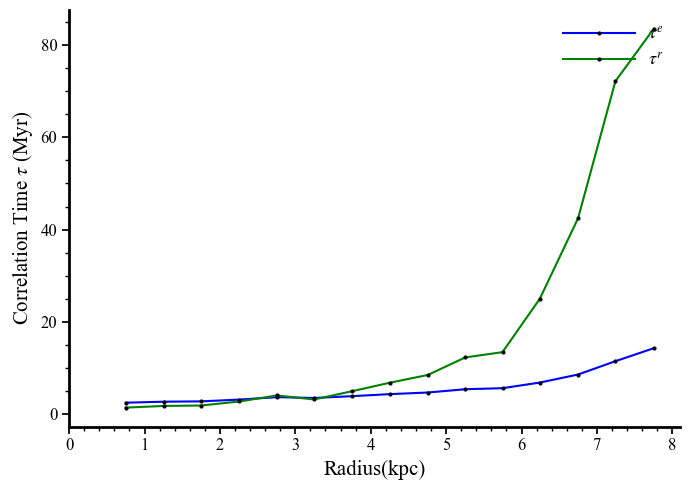

In [16]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, taue_f/s_Myr, c='b', markersize=m,
              linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^e$')
ax.plot(kpc_r, taur_f/s_Myr, c='g',
              markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^r$')
ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'Correlation Time $\tau$ (Myr)', fontsize=fs)
axis_pars(ax)


plt.savefig(save_files_dir+r'\9a tau_e vs tau_r')

dkdc_f [] []
[] []


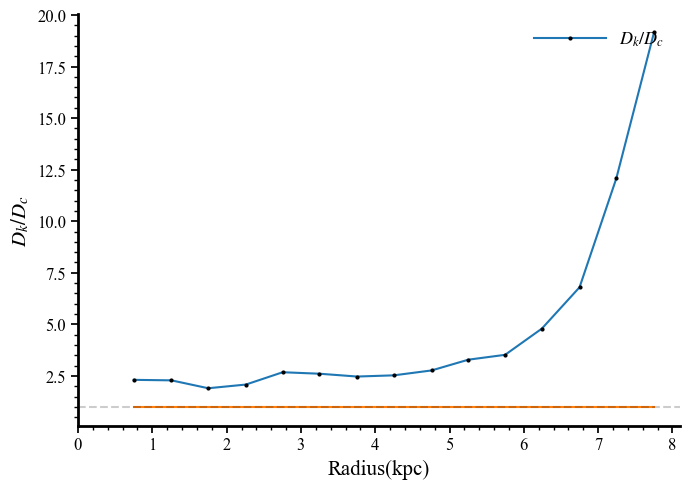

In [17]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

ax.plot(kpc_r, dkdc_f, markersize=m, linestyle='-',
              marker='o', mfc='k', mec='k', label=r'$D_k/D_c$')
ax.plot(kpc_r, 1*np.ones(len(kpc_r)))
ax.axhline(y=1, color='black', linestyle='--', alpha = 0.2)

ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'$D_k/D_c$',  fontsize=fs)
axis_pars(ax)

index_sup = np.where(kpc_r== 8.75)
index_sub = np.where(kpc_r== 14.25)
print('dkdc_f',dkdc_f[index_sup],kpc_r[index_sup])
print(dkdc_f[index_sub],kpc_r[index_sub])
plt.savefig(save_files_dir+r'\10 Dk by Dc')


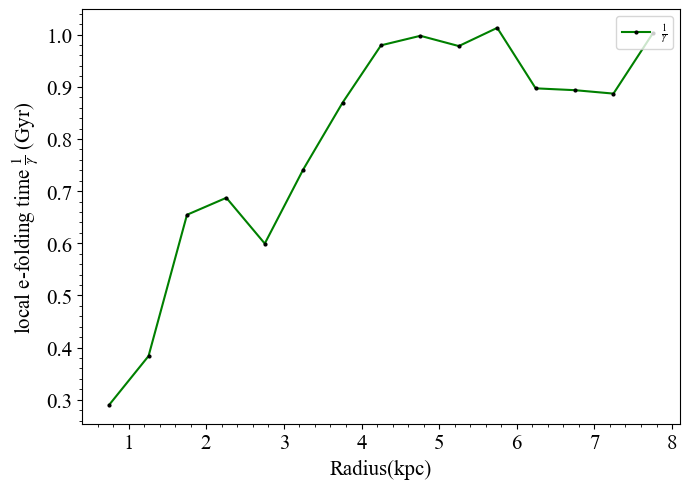

In [18]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, (((np.pi**2)*(tau_f*(u_f**2))/3*(np.sqrt(dkdc_f)-1)/(4*h_f**2))**(-1))/
              (s_Myr*1e+3), c='g', markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\frac{1}{\gamma}$')
ax.set_xlabel('Radius(kpc)', fontsize=fs)
ax.set_ylabel(r'local e-folding time $\frac{1}{\gamma}$ (Gyr)', fontsize=fs)
ax.legend(fontsize = lfs)


plt.savefig(save_files_dir+r'\11 e-folding time')


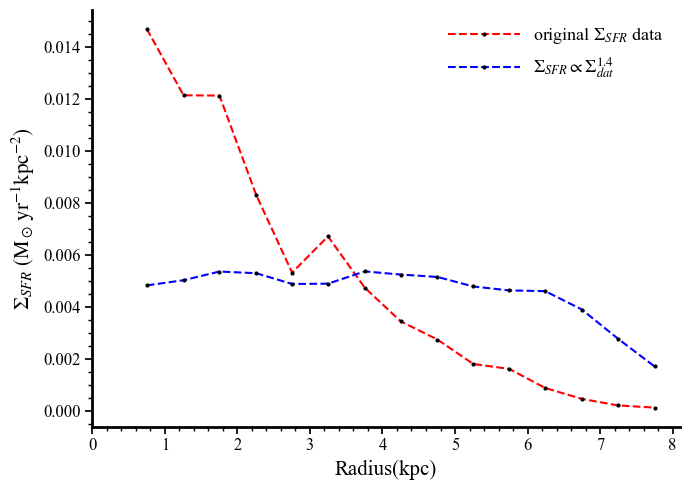

In [19]:
dat_sigmatot, dat_sigma, dat_sigmasfr, dat_q, dat_omega, zet, T_tb, psi, bet, ca, rk, mu, A = (
    np.array([data_pass[i][j] for i in range(len(kpc_r))]) for j in range(len(data_pass[0])))
from helper_functions import g_Msun
ks_const = (dat_sigmasfr/(dat_sigma)**(1.4)).mean()
dat_sigmasfr2 = ks_const*(dat_sigma)**(1.4)
dat_sigma3 = ((1/ks_const)*(dat_sigmasfr))**(1/1.4)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

ax.plot(kpc_r, dat_sigmasfr*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='r',
           linestyle='--', mfc='k', mec='k', markersize=m, marker='o', label=r'original $\Sigma_{SFR}$ data')
ax.plot(kpc_r, dat_sigmasfr2*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='b', linestyle='--',
           mfc='k', mec='k', markersize=m, marker='o', label=r'$\Sigma_{SFR} \propto \Sigma_{dat}^{1.4}$ ')
# ax.plot(kpc_r, dat_sigma3*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='g', linestyle='--',
#            mfc='k', mec='k', markersize=m, marker='o', label=r'$\Sigma \propto \Sigma_{SFRdat}^{1/1.4}$')
ax.set_xlabel('Radius(kpc)',fontsize=fs)
ax.set_ylabel(r'$\Sigma_{SFR}$ ($\mathrm{M_\odot\,yr^{-1}kpc^{-2}}$)',fontsize=fs)
axis_pars(ax)

plt.savefig(save_files_dir+r'\12 sfr')


In [20]:
# os.chdir(saver)

# # #change pdf name here for different galaxies

# from matplotlib.backends.backend_pdf import PdfPages
# PDF = PdfPages('m33_model3_ca_'+str(params[r'C_\alpha'])+'rk_'+str(params[r'R_\kappa'])+'z_'+str(
#      params[r'\zeta'])+'psi_'+str(params[r'\psi'])+'b_'+str(params[r'\beta'])+'.pdf')#('plots_model'+str(model_no)+let+'t_vary_'+'ca_'+str(ca)+'rk_'+str(rk)+'z_'+str(z.mean())+'.pdf')
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)
# i = 0
# j = 0
# ax[i][j].plot(kpc_r, h_f*pc_kpc/cm_kpc, c='r', linestyle='-', mfc='k',
#               mec='k', markersize=m, marker='o', label=r' $h$(pc)')
# ax[i][j].plot(kpc_dat_r, pc_dat_h, c='b', linestyle='dotted', 
#               marker='*',mfc='y',mec='b',mew=1, markersize = 7, label=r'Fiducial values from Chamandy et.al.(2016) $h(pc)$')
# ax[i][j].plot(kpc_r, l_f*pc_kpc/cm_kpc, c='g',
#               linestyle='-', mfc='k', mec='k', markersize=m, marker='o', label=r'Correlation length l(pc)')
# # ax[i][j].plot(kpc_r, datamaker(lsn , data_pass, h_f, tau_f)*pc_kpc/cm_kpc,c = 'y',linestyle='--',mfc='k',mec='k', marker='o')
# ax[i][j].axhline(y=100, color='black', linestyle='--', alpha = 0.2)
# ax[i][j].set_yticks(list(plt.yticks()[0])+[100])
# axis_pars(ax[i][j])
# fill_error(ax[i][j], h_f*pc_kpc/cm_kpc, h_err*pc_kpc/cm_kpc)
# ax[i][j].set_xlabel(r'Radius (kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'Length scale (pc)', fontsize=fs)


# i = 0
# j = 1
# ax[i][j].plot(kpc_r, u_f/cm_km, color='tab:orange', marker='o', mfc='k',
#               mec='k', markersize=m, label=r'$u$')
# fill_error(ax[i][j], u_f/cm_km,u_err/cm_km, 'tab:orange', 0.5)

# ax[i][j].plot(kpc_r, alphak_f/cm_km, color='b', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_k$')
# fill_error(ax[i][j], alphak_f/cm_km,alphak_err/cm_km, 'blue')

# ax[i][j].plot(kpc_r, alpham_f/cm_km, color='r', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_m$')
# ax[i][j].plot(kpc_r, alphasat_f/cm_km, color='m', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_{sat}$')

# sig = np.sqrt(u_f**2 + cs_f**2) 
# ax[i][j].plot(kpc_r, sig /
#               cm_km, color='r', marker='o', mfc='k', mec='k', markersize=m, label=r'$\sqrt{u^2+c_s^2}$')
# fill_error(ax[i][j], sig /cm_km,np.sqrt((u_f*u_err)**2 + (cs_f*cs_err)**2)/(sig*cm_km), 'r')

# ax[i][j].plot(kpc_r, cs_f /
#               cm_km, color='g', linestyle='--', label=r'$c_s$', alpha = 0.5)
# fill_error(ax[i][j], cs_f/cm_km,cs_err/cm_km, 'green')

# ax[i][j].plot(kpc_r, dat_u/cm_km, 
#               c='y', linestyle='--', label='Without warp',alpha = 1,marker='*',mfc='y'
# ,mec='k',mew=1, markersize = 7)
# # ax[i][j].plot(kpc_r, dat_u_warp/cm_km, 
# #               c='tab:cyan',  linestyle='dashdot', label='With warp', alpha = 0.3,marker='*',mfc='tab:cyan'
# # ,mec='k',mew=1, markersize = 7)
# axis_pars(ax[i][j])

# ax[i][j].set_ylim(0)
# ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
# ax[i][j].set_ylabel(r'Speed (km/s)',  fontsize=fs)

# i = 1

# # ###############################################    M31    ###############################################
# # # ax[i][j].errorbar(rmrange, 180*RM_dat_pb/np.pi,elinewidth=1, yerr=180*err_RM_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
# # #                   c='r', linestyle='--', mfc='r', mec='k',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
# # # ax[i][j].errorbar(rmrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
# # #                   c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')
# # ###############################################    M31    ###############################################

# # ###############################################    M33    ###############################################
# # ax[i][j].errorbar(mrange, 180*M_dat_pb/np.pi,elinewidth=1, yerr=180*err_M_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
# #                   c='r', linestyle='--', mfc='r', mec='k',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
# # ax[i][j].errorbar(po_mrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
# #                   c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')
# # ###############################################    M33    ###############################################

# # ###############################################    6946    ###############################################
# # # ax[i][j].errorbar(range1, 180*RM_dat_po_range1/np.pi,elinewidth=1, yerr=180*err_RM_dat_po_range1/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
# # #                   c='r', linestyle='--', mfc='r', mec='k',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
# # # ax[i][j].errorbar(range2, 180*RM_dat_po_range2/np.pi,elinewidth=1, yerr=180*err_RM_dat_po_range2/np.pi, ms=7, mew=1, capsize=2,
# # #                   c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')
# # ###############################################    6946    ###############################################

# ax[i][j].plot(kpc_r, 180*pB/np.pi, c='r', linestyle='-', marker='o',
#               markersize=m, mfc='k', mec='k', label=r' $p_{B}$ (mean field)')
# fill_error(ax[i][j], 180*pB/np.pi,180*pB_err/np.pi, 'r')
# ax[i][j].plot(kpc_r, 180*pbb/np.pi,c = 'r',linestyle='--', marker='o',label = r' $p_{b}$ (anisotropic field)')
# ax[i][j].plot(kpc_r, 180*pog/np.pi, c='g', linestyle='-', mfc='k', markersize=m,
        
#               mec='k', marker='o', label=r' $p_{o}$ (ordered field)')
# fill_error(ax[i][j], 180*pog/np.pi,180*pog_err/np.pi, 'g')

# axis_pars(ax[i][j])
# ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
# ax[i][j].set_ylabel(r'Pitch angle (deg)', fontsize=fs)

# j= 0
# ax[i][j].plot(mrange, G_dat_Btot, c='b', linestyle='--', marker='*',mfc='yellow',mec
# ='tab:blue',mew=1,markersize = 7)#, label='Average Binned data $B_{tot}$ ($\mu G$)')
# ax[i][j].plot(kpc_r, G_scal_Bbartot*1e+6, c='b', linestyle='-', marker='o', mfc='k', mec='k',
#               markersize=m, label=r' $B_{tot}=\sqrt{\bar{B}^2+b_{iso}^2+b_{ani}^2}$')
# fill_error(ax[i][j], G_scal_Bbartot*1e+6,G_scal_Bbartot_err*1e+6, 'b')

# ax[i][j].plot(mrange, G_dat_Breg, c='r', linestyle='--', marker='*',mfc='yellow',mec
# ='tab:red',mew=1,markersize = 7)#, label='Average Binned data $B_{reg}$ ($\mu G$)')
# ax[i][j].plot(kpc_r, G_scal_Bbarreg*1e+6, c='r', linestyle='-', marker='o',
#               mfc='k', mec='k', markersize=m, label=r' $B_{reg} = \bar{B}$')
# fill_error(ax[i][j], G_scal_Bbarreg*1e+6,G_scal_Bbarreg_err*1e+6, 'r', 0.2)


# ax[i][j].plot(mrange, G_dat_Bord, c='g', linestyle='dotted', marker='*',mfc='yellow'
# ,mec='green',mew=1,markersize = 7)#, label='Average Binned data $B_{ord}$ ($\mu G$)')
# ax[i][j].plot(kpc_r, G_scal_Bbarord*1e+6, c='green', linestyle='-', marker='o', mfc='k',
#               mec='k', markersize=m, label=r' $B_{ord} = \sqrt{\bar{B}^2+b_{ani}^2}$')
# fill_error(ax[i][j], G_scal_Bbarord*1e+6,G_scal_Bbarord_err*1e+6, 'g', 0.2)


# ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
# ax[i][j].xaxis.set_ticks(np.arange(1, 7, 2))
# ax[i][j].xaxis.set_major_formatter(FormatStrFormatter('%g'))
# ax[i][j].set_ylabel('Magnetic field strength ($\mu G$)', fontsize=fs)
# axis_pars(ax[i][j])


# PDF.savefig(fig)
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

# i = 0

# ax[i][j].axhline(y=1, color='g', linestyle='-', label=r'1')
# ax[i][j].plot(kpc_r, omt, marker='o', markersize=m,
#               c='tab:orange', mfc='k', mec='k', label=r'$\Omega\tau$')
# ax[i][j].plot(kpc_r, kah, marker='o',
#               markersize=m, c='tab:blue', mfc='k', mec='k', label=r'$\frac{K_\alpha h}{C_\alpha \tau u}$')
# axis_pars(ax[i][j])
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'Condition for $\alpha_k$ (Myr)', fontsize=fs)


# j = 1
# ax[i][j].plot(kpc_r, taue_f/s_Myr, c='b', markersize=m,
#               linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^e$')
# ax[i][j].plot(kpc_r, taur_f/s_Myr, c='g',
#               markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^r$')
# ax[i][j].plot(kpc_r, h_f/(u_f*s_Myr), c='y', markersize=m,
#               linestyle='-', marker='o', mfc='k', mec='k', label=r'$h/u$')
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'Correlation Time $\tau$ (Myr)', fontsize=fs)
# axis_pars(ax[i][j])

# i = 1
# ax[i][j].plot(kpc_r, dkdc_f, markersize=m, linestyle='-',
#               marker='o', mfc='k', mec='k', label=r'$D_k/D_c$')
# ax[i][j].plot(kpc_r, 1*np.ones(len(kpc_r)))
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'$D_k/D_c$',  fontsize=fs)
# axis_pars(ax[i][j])

# j = 0
# ax[i][j].plot(kpc_r, (((np.pi**2)*(tau_f*(u_f**2))/3*(np.sqrt(dkdc_f)-1)/(4*h_f**2))**(-1))/
#               (s_Myr*1e+3), c='g', markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\gamma$')
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'local e-folding time $\gamma$ (Gyr)', fontsize=fs)
# ax[i][j].legend(fontsize = lfs)

# PDF.savefig(fig)
# PDF.close()
# os.chdir(current_directory)


In [21]:
os.chdir(current_directory)
